# figures_draft2017b.ipynb

## Purpose
Produce figures for *"Effective radiative forcing in the aerosol-climate model CAM5.3-MARC-ARG"*, based on results from project [p17c-marc-comparison](https://github.com/grandey/p17c-marc-comparison).

## Requirements
- NetCDF files produced by [analysis_cdo_nco_draft2017b.ipynb](https://github.com/grandey/p17c-marc-comparison/blob/master/manuscript_draft2017b/analysis_cdo_nco_draft2017b.ipynb).
- Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy).

## Author
Benjamin S. Grandey, 2017

In [1]:
import climapy
from glob import glob
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
import scipy
from scipy import stats
import xarray as xr

# Print versions of packages
for module in [climapy, np, pd, scipy, xr]:
    try:
        print('{}.__version__ = {}'.format(module.__name__, module.__version__))
    except AttributeError:
        pass

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 40  # reduce resolution of inline figures to reduce notebook size

climapy.__version__ = 0.0.1+54ace0a
numpy.__version__ = 1.13.3
pandas.__version__ = 0.21.0
scipy.__version__ = 0.19.1
xarray.__version__ = 0.9.6


## Post-processed data file location
Location of files written by [analysis_cdo_nco_draft2017b.ipynb](https://github.com/grandey/p17c-marc-comparison/blob/master/manuscript_draft2017b/analysis_cdo_nco_draft2017b.ipynb).

In [2]:
in_dir = os.path.expandvars('$HOME/data/projects/p17c_marc_comparison/analysis_cdo_nco_draft2017b/')

## Function to produce zonal mean line plot
- Put latitude on y-axis for consistency with maps

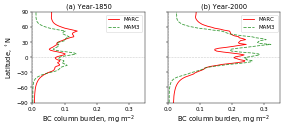

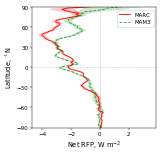

In [3]:
def zonal_mean_line_plot(year='2000', model_var_dict={'mam3': 'BURDENPOM'}, domain='atm',
                         sf=None, xlabel=None, xlim=None,
                         ylabel=True, 
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # Loop over model-variable combinations
    for model, variable in model_var_dict.items():
        if variable is not None:
            # Color based on model
            if model == 'marc':
                c = 'r'
                alpha = 1
                linestyle = '-'
            elif model == 'mam3':
                c = 'g'
                alpha = 0.75
                linestyle = '--'
            elif model == 'mam7':
                c = 'b'
                alpha = 0.5
                linestyle = ':'
            # Case 1: single year (1850 or 2000)
            if year in ['1850', '2000']:
                # Load annual mean data
                in_filename = '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, year, variable)
                data = xr.open_dataset(in_filename, decode_times=False)
                data = data.isel(time=slice(2, None))  # exlcude first two years as spin-up
                data = climapy.cesm_time_from_bnds(data)  # populate time dimension using climapy
                # Calculate zonal mean
                zm = data.mean(dim='lon')
                # If 3D field, get data for surface
                if 'lev' in zm.dims:
                    zm = zm.isel(lev=-1)
                # Plot line - showing mean across time
                tm = zm.mean(dim='time')[variable].data.flatten() * sf
                ax.plot(tm, zm['lat'].data,
                        c=c, alpha=alpha, linestyle=linestyle,
                        label=model.upper())
                # Plot shading - based on standard error
                error = zm.std(dim='time', ddof=1)[variable].data.flatten() / np.sqrt(zm['time'].size) * sf
                ax.fill_betweenx(zm['lat'].data, tm-error, tm+error,
                                 facecolor=c, alpha=0.2)
                # Close dataset
                data.close()
            # Case 2: difference (2000-1850)
            if year == '2000-1850':
                # Load annual mean data
                in_filename1 = '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '2000', variable)
                in_filename2 = '{}/{}_{}_{}_ANN.nc'.format(in_dir, model, '1850', variable)
                data1 = xr.open_dataset(in_filename1, decode_times=False)
                data1 = data1.isel(time=slice(2, None))
                data1 = climapy.cesm_time_from_bnds(data1)
                data2 = xr.open_dataset(in_filename2, decode_times=False)
                data2 = data2.isel(time=slice(2, None))
                data2 = climapy.cesm_time_from_bnds(data2)
                # Calculate zonal means
                zm1 = data1.mean(dim='lon')
                zm2 = data2.mean(dim='lon')
                # If 3D field, get data for surface
                if 'lev' in zm1.dims:
                    zm1 = zm1.isel(lev=-1)
                    zm2 = zm2.isel(lev=-1)
                # Plot line - showing difference of means across time
                tm1 = zm1.mean(dim='time')[variable].data.flatten() * sf
                tm2 = zm2.mean(dim='time')[variable].data.flatten() * sf
                tm = tm1 - tm2
                ax.plot(tm, zm1['lat'].data,
                        c=c, alpha=alpha, linestyle=linestyle,
                        label=model.upper())
                # Plot shading - based on combined standard error
                error1 = zm1.std(dim='time', ddof=1)[variable].data.flatten() / np.sqrt(zm1['time'].size) * sf
                error2 = zm2.std(dim='time', ddof=1)[variable].data.flatten() / np.sqrt(zm2['time'].size) * sf
                error = np.sqrt(error1**2 + error2**2)
                ax.fill_betweenx(zm1['lat'].data, tm-error, tm+error,
                                 facecolor=c, alpha=0.2)
                # Close datasets
                data1.close()
                data2.close()
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='large')
    # x-axis
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='large')
    ax.legend()
    return ax

# Examples
if True:
    # Example 1
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
    for year, ylabel, title, ax in zip(['1850', '2000'], [True, False], ['(a) Year-1850', '(b) Year-2000'], axs):
        zonal_mean_line_plot(year=year, model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'},
                             sf=1e6, xlabel=r'BC column burden, mg m$^{-2}$', xlim=[0, 0.35],
                             ylabel=ylabel, title=title, ax=ax)
    # Example 2
    ax = zonal_mean_line_plot(year='2000-1850', model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'},
                              xlabel=r'Net RFP, W m$^{-2}$')